# Transfer learning with TFhub

* [source site](https://www.tensorflow.org/beta/tutorials/images/hub_with_keras)

### following codes

1. load pretrained model - trained with imagenet. model architecture mobilenet
1. load grace hopper photo
1. test the photo to pretraine model

In [1]:
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

In [2]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [3]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,)) # RGB channel
])

In [4]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

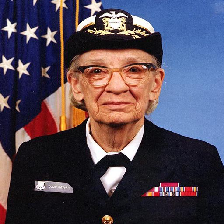

In [31]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [32]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [33]:
result = classifier.predict(grace_hopper[np.newaxis, ...]) # it make like as dataset.

(1, 1001)

In [37]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [38]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 1us/step


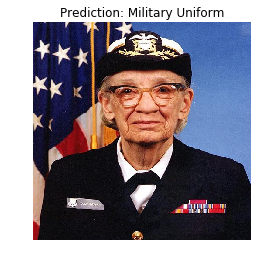

In [39]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Transfer learning

In [41]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

In [42]:
data_root

'/home/hyunsu/.keras/datasets/flower_photos'

In [43]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [45]:
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [48]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [49]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', "jack-o'-lantern", 'hip', 'stage', 'stone wall',
       'ladybug', 'hip', 'hip', 'head cabbage', 'mushroom', 'daisy',
       'rapeseed', 'clog', 'tray', 'picket fence', 'daisy', 'daisy',
       'daisy', 'picket fence', "jack-o'-lantern", 'bee', 'macaw',
       'daisy', 'spider web', 'daisy', 'picket fence', 'daisy', 'bee',
       'lemon', 'daisy', 'cardoon', 'clog'], dtype='<U30')

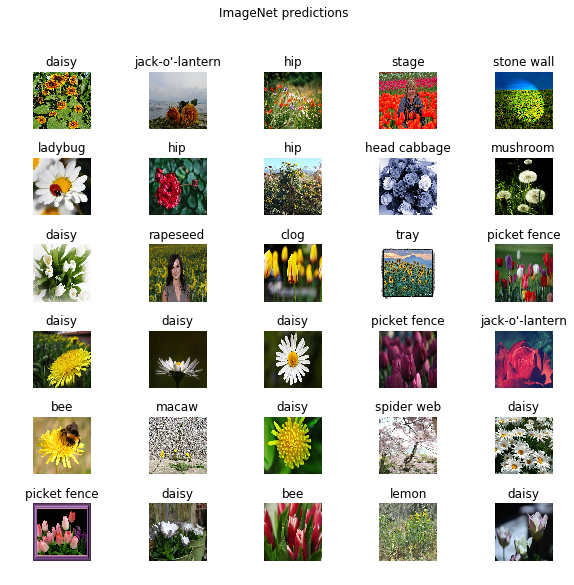

In [50]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions") 
# before trained with specific dataset. just use imagenet label.

### Use headless model

In [51]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

In [52]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [55]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape) # it's headless, has no classification(softmax) layer

(32, 1280)


In [61]:
feature_extractor_layer.trainable = False # freeze pretrained layer

In [62]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary() # just add softmax layer to pretrained model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [63]:
predictions = model(image_batch)

In [64]:
predictions.shape # the flower data has 5 labels.

TensorShape([32, 5])

In [65]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [66]:
class CollectBatchStats(tf.keras.callbacks.Callback): # to viualize training progress.
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics() # not epoch average, but each batch average

In [67]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size) # make bigger integer

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=2,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats_callback])

W0627 19:26:50.703961 140170481411904 deprecation.py:323] From /home/hyunsu/anaconda3/envs/tf20_py36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2
115/115 [==============================] - 12s 107ms/step - loss: 0.8533 - acc: 0.8438
Epoch 2/2
115/115 [==============================] - 11s 95ms/step - loss: 0.5051 - acc: 0.9688


In [71]:
np.ceil(image_data.samples/image_data.batch_size)

115.0

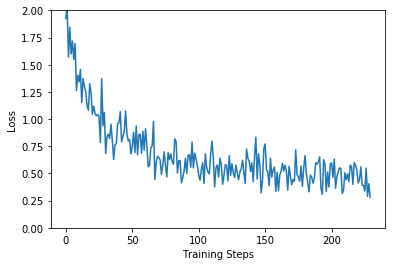

In [74]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

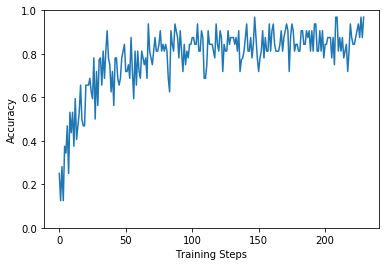

In [78]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [79]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
# .title() : return string with capitalizing the first letter.
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [93]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [94]:
label_id = np.argmax(label_batch, axis=-1)

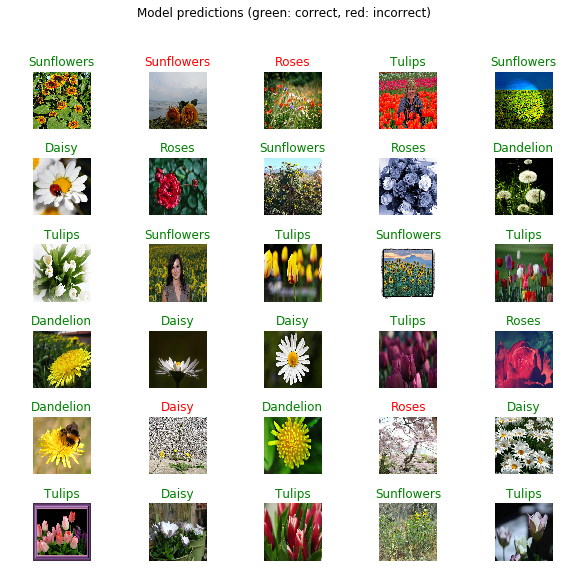

In [96]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

### below here, experimental code was applied.


In [97]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.experimental.export_saved_model(model, export_path)

export_path

W0627 19:58:16.164666 140170481411904 deprecation.py:323] From /home/hyunsu/anaconda3/envs/tf20_py36/lib/python3.6/site-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:253: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
W0627 19:58:16.165315 140170481411904 export_utils.py:182] Export includes no default signature!
W0627 19:58:16.769639 140170481411904 meta_graph.py:450] Issue encountered when serializing variables.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
W0627 19:58:21.010475 140170481411904 export_utils.py:182] Export includes no default signature!
W0627 19:58:

'/tmp/saved_models/1561633091'

In [98]:
reloaded = tf.keras.experimental.load_from_saved_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [99]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [100]:
abs(reloaded_result_batch - result_batch).max()

0.0